In [1]:
import tifffile as tiff
import pandas as pd
import os
from matplotlib import pyplot as plt
import gc
import rasterio
import numpy as np
from model import utils
from model import datagen

In [2]:
train_df = pd.read_csv(utils.TRAIN_PATH)
train_df.head()

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


In [3]:
tiff_name = train_df['id'][0]
tiff_path = os.path.join(utils.TRAIN_DIR, f'{tiff_name}.tiff')
encoding = train_df['encoding'][0]
tiff_path

'/data/kaggle/hubmap/train/2f6ecfcdf.tiff'

In [4]:
with rasterio.open(tiff_path, transform=rasterio.Affine(1, 0, 0, 0, 1, 0)) as tiff_reader:
    shape = tiff_reader.shape
shape

/home/nishaq/Documents/kaggle/.kaggle/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(31278, 25794)

In [7]:
tile_gen = datagen.tiff_tile_generator(
    tiff_path=tiff_path,
    encoding=encoding,
    tile_size=512,
    min_overlap=128,
)
count = 0
full_mask = np.zeros(shape, dtype=np.uint8)
glom_mask = np.zeros(shape, dtype=np.uint8)
for _, mask, x1, x2, y1, y2 in tile_gen:
    count += 1
    if count % 100 == 0:
        print(count, end=' ' if count % 1000 != 0 else '\n')
    if mask.sum() > 0:
        full_mask[x1:x2, y1:y2] = 1
    glom_mask[x1:x2, y1:y2] = mask
print(count)

num_slices: 5576
100
200
300
400
500
600
700
800
900
1000 1100
1200
1300
1400
1500
1600
1700
1800
1900
2000 2100
2199


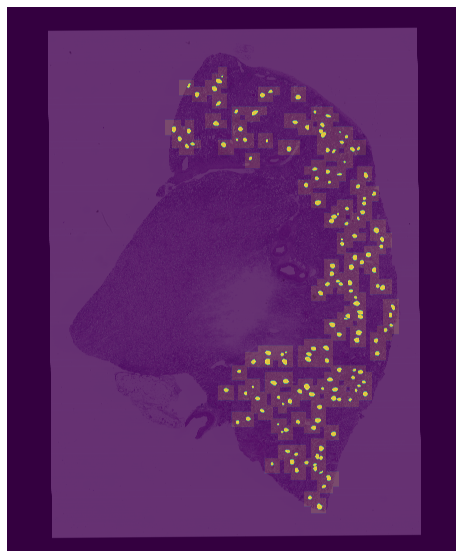

3300

In [8]:
image = tiff.imread(tiff_path)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(full_mask, alpha=1 / 3)
plt.imshow(glom_mask, alpha=2 / 3)
plt.axis('off')
plt.show()
del image
del full_mask
del glom_mask
gc.collect()